# **Recomendation System - Collaborative Filtering**

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

# **Imports**

Import common libraries that will be used

In [1]:
import numpy as np
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

# **Upload Dataset**

upload datasets from the database

In [2]:
base_url = 'https://cloud-computing-chi.vercel.app/ml/'

# Replace path with URL
url_to_course = base_url + 'courses'
url_to_user = base_url + 'users'
url_to_rating = base_url + 'user-rating'

# **Read Data**

## **Course**

In [3]:
# Reading JSON from URL
response = requests.get(url_to_course)
json_data = response.json()

# Convert JSON to DataFrame
courses = pd.json_normalize(json_data, 'data')
courses.head()

,id,created_at,title,link,organizer,category,instructor,level,rating,fee,description,image
0,1,2023-12-16T16:47:23.175286+00:00,"¡Luces, celular y acción!Crea contenidosaudiov...",https://www.edx.org/learn/marketing/pontificia...,Pontificia Universidad Javeriana,Communication,None,Introductory,None,None,"Smartphone Operation, Value Propositions, Mark...",https://prod-discovery.edx-cdn.org/media/cours...
1,2,2023-12-16T16:47:23.175286+00:00,3D CAD Fundamental,https://www.coursera.org/learn/3d-cad-fundamental,Coursera,Graphic Design,康仕仲,None,4.7,Gratis,There have many three-dimensional shape of the...,https://d3njjcbhbojbot.cloudfront.net/api/util...
2,3,2023-12-16T16:47:23.175286+00:00,A Fun Collage - with 30+ Examples,https://www.udemy.com/course/5-minute-collage/,Udemy,Graphic Design,Mike Merkur,None,4.0,Gratis,How to Put Together a Photo CollageHow to use ...,https://img-b.udemycdn.com/course/240x135/3569...
3,4,2023-12-16T16:47:23.175286+00:00,A travel by SpanishAmerica: Spanish forbeginners,https://www.edx.org/learn/spanish/universidad-...,Universidad del Rosario,Language,None,Introductory,None,None,Spanish Language,https://prod-discovery.edx-cdn.org/media/cours...
4,5,2023-12-16T16:47:23.175286+00:00,Academic and BusinessWriting,https://www.edx.org/learn/writing/university-o...,"University of California, Berkeley",Communication,None,Introductory,None,None,"Diction, Business Writing, Writing, Vocabulary...",https://prod-discovery.edx-cdn.org/media/cours...


In [4]:
courses.shape

(322, 12)

In [5]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           322 non-null    int64 
 1   created_at   322 non-null    object
 2   title        322 non-null    object
 3   link         322 non-null    object
 4   organizer    322 non-null    object
 5   category     322 non-null    object
 6   instructor   226 non-null    object
 7   level        153 non-null    object
 8   rating       211 non-null    object
 9   fee          226 non-null    object
 10  description  322 non-null    object
 11  image        322 non-null    object
dtypes: int64(1), object(11)
memory usage: 30.3+ KB


## **User Rating**

In [6]:
# Reading JSON from URL
response = requests.get(url_to_rating)
json_data = response.json()

# Convert JSON to DataFrame
ratings = pd.json_normalize(json_data, 'data')
ratings.head()

,id,created_at,course_id,user_id,user_rating
0,2,2023-12-20T06:55:04.830512+00:00,9,1,3
1,3,2023-12-20T06:55:04.830512+00:00,56,1,5
2,4,2023-12-20T06:55:04.830512+00:00,24,1,5
3,5,2023-12-20T06:55:04.830512+00:00,15,1,4
4,6,2023-12-20T06:55:04.830512+00:00,16,1,3


In [7]:
ratings.shape

(4841, 5)

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4841 entries, 0 to 4840
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           4841 non-null   int64 
 1   created_at   4841 non-null   object
 2   course_id    4841 non-null   int64 
 3   user_id      4841 non-null   int64 
 4   user_rating  4841 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 189.2+ KB


In [9]:
print(ratings.user_id.unique())
print(ratings.course_id.unique())
ratings.isna().sum()

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 159 150 151 152 153 154 155 156 157 158 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

id             0
created_at     0
course_id      0
user_id        0
user_rating    0
dtype: int64

# **Split Data for Training 80% and for Test 20%**

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (3872, 5)
Shape of test data: (969, 5)


In [11]:
# Train data
train.head()

,id,created_at,course_id,user_id,user_rating
432,434,2023-12-20T06:55:04.830512+00:00,28,22,5
3427,3429,2023-12-20T06:55:04.830512+00:00,272,172,4
289,291,2023-12-20T06:55:04.830512+00:00,46,15,5
3279,3281,2023-12-20T06:55:04.830512+00:00,289,163,5
4116,4118,2023-12-20T06:55:04.830512+00:00,308,210,4


In [12]:
# Test data
test.head()

,id,created_at,course_id,user_id,user_rating
3200,3202,2023-12-20T06:55:04.830512+00:00,282,159,5
2527,2529,2023-12-20T06:55:04.830512+00:00,243,122,4
4102,4104,2023-12-20T06:55:04.830512+00:00,309,209,4
1926,1928,2023-12-20T06:55:04.830512+00:00,73,90,3
1536,1538,2023-12-20T06:55:04.830512+00:00,132,73,3


# **Number Unique**

In [13]:
# unique_users = train['user_id'].unique()
# print("Unique Users:", unique_users)
# print("Number of Unique Users:", len(unique_users))

# unique_courses = train['course_id'].unique()
# print("\nUnique Courses:", unique_courses)
# print("Number of Unique Courses:", len(unique_courses))


In [14]:
max_user_id = train['user_id'].max()
max_course_id = train['course_id'].max()
max_id = train['id'].max()
print("Maximum User ID:", max_user_id)
print("Maximum Course ID:", max_course_id)
print("Maximum ID:", max_id)

Maximum User ID: 259
Maximum Course ID: 322
Maximum ID: 4842


# **Building the recommendation engine using TensorFlow / Keras**

In [15]:
#course input network
input_course = tf.keras.layers.Input(shape=[1], name="Course-Input")
embed_course = tf.keras.layers.Embedding(max_course_id+1, 5)(input_course)
course_out = tf.keras.layers.Flatten()(embed_course)

#user input network
input_users = tf.keras.layers.Input(shape=[1])
embed_users = tf.keras.layers.Embedding(max_user_id+1, 5, name="User-Input")(input_users)
users_out = tf.keras.layers.Flatten()(embed_users)

conc_layer = tf.keras.layers.Concatenate()([course_out, users_out])
dropout_layer = tf.keras.layers.Dropout(0.2)(conc_layer)
x = tf.keras.layers.Dense(128, activation='relu')(dropout_layer)
x_out = tf.keras.layers.Dense(1, activation='relu')(x)
model = tf.keras.Model([input_course, input_users], x_out)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 5)                 1615      ['Course-Input[0][0]']        
                                                                                                  
 User-Input (Embedding)      (None, 1, 5)                 1300      ['input_1[0][0]']             
                                                                                              

In [17]:
history = model.fit([train.course_id, train.user_id], train.user_rating,
                      batch_size=64,
                      epochs=5,
                      verbose=1,
                      validation_data=([test.course_id, test.user_id], test.user_rating))

Epoch 1/5
61/61 [==============================] - 1s 7ms/step - loss: 14.2062 - val_loss: 10.0906
Epoch 2/5
61/61 [==============================] - 0s 3ms/step - loss: 5.0424 - val_loss: 1.0479
Epoch 3/5
61/61 [==============================] - 0s 3ms/step - loss: 0.8261 - val_loss: 0.7391
Epoch 4/5
61/61 [==============================] - 0s 3ms/step - loss: 0.7282 - val_loss: 0.7414
Epoch 5/5
61/61 [==============================] - 0s 4ms/step - loss: 0.6884 - val_loss: 0.7456


# **Plot Metrics**


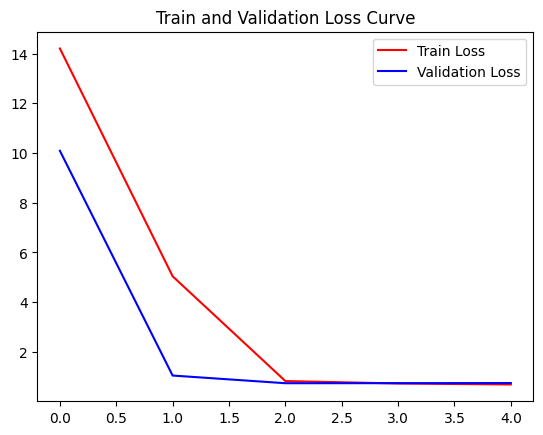

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

# **Check Loss**

In [19]:
# Assuming you have test data: test.course_id, test.user_id, test.user_rating
loss = model.evaluate([test.course_id, test.user_id], test.user_rating)
print("Test Loss:", loss)

31/31 [==============================] - 0s 2ms/step - loss: 0.7456
Test Loss: 0.7456205487251282


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on training and testing data
train_predictions = model.predict([train.course_id, train.user_id])
test_predictions = model.predict([test.course_id, test.user_id])

# Calculate evaluation metrics
train_mse = mean_squared_error(train.user_rating, train_predictions)
test_mse = mean_squared_error(test.user_rating, test_predictions)

print(f'Train MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')


31/31 [==============================] - 0s 2ms/step
Train MSE: 0.5881
Test MSE: 0.7456


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Calculate the average score on the training data
mean_rating = train.user_rating.mean()

# Step 2: Basic model predictions
baseline_predictions = np.full_like(test.user_rating, mean_rating)

# Step 3: Evaluate with MSE or MAE
mse_model = mean_squared_error(test.user_rating, model.predict([test.course_id, test.user_id]))
mae_model = mean_absolute_error(test.user_rating, model.predict([test.course_id, test.user_id]))

mse_baseline = mean_squared_error(test.user_rating, baseline_predictions)
mae_baseline = mean_absolute_error(test.user_rating, baseline_predictions)

# Step 4: Comparison
print("Model Regression MSE:", mse_model)
print("Baseline Model MSE:", mse_baseline)

print("Model Regression MAE:", mae_model)
print("Baseline Model MAE:", mae_baseline)

31/31 [==============================] - 0s 2ms/step
Model Regression MSE: 0.7456205597939659
Baseline Model MSE: 0.673890608875129
Model Regression MAE: 0.7458214486715594
Baseline Model MAE: 0.673890608875129


# **Model Save**

In [22]:
model.save('recommendation_rating_model.h5')
model.save('my_model.keras')

# **Making Recommendations for Users**

In [23]:
#Making recommendations
course_id = range(1,322) # input course IDs
course_arr = np.array(course_id) #get all course IDs

In [24]:
user_id = 96 # input user id
user = np.array([user_id for i in range(len(course_id))]) # check for user
pred = model.predict([course_arr, user])
pred

11/11 [==============================] - 0s 3ms/step


array([[4.0520983],
       [3.4159749],
       [3.6779282],
       [3.7983744],
       [3.9023623],
       [3.6757152],
       [4.0793858],
       [4.1744485],
       [3.953435 ],
       [4.179791 ],
       [3.923646 ],
       [3.590805 ],
       [3.850932 ],
       [3.8416936],
       [3.601722 ],
       [4.0843973],
       [3.776942 ],
       [3.9007685],
       [3.5503237],
       [4.301933 ],
       [3.756633 ],
       [4.035279 ],
       [3.821081 ],
       [4.1674237],
       [3.7948449],
       [3.6667626],
       [3.8295171],
       [4.1776214],
       [4.0020113],
       [3.818484 ],
       [3.834484 ],
       [3.9589255],
       [3.994676 ],
       [3.9784024],
       [4.0564013],
       [4.101125 ],
       [4.036871 ],
       [3.8343709],
       [3.8179886],
       [3.846473 ],
       [4.0515113],
       [3.7590897],
       [3.9654934],
       [3.8388314],
       [3.8654253],
       [3.8108137],
       [3.778012 ],
       [3.5502827],
       [3.8524816],
       [3.667339 ],


In [25]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:10] # predict 10 courses

In [26]:
# print predicted scores
pred_ids

array([310, 246, 302,  19, 319, 269, 314, 283, 226, 318])

In [27]:
courses.iloc[pred_ids]

,id,created_at,title,link,organizer,category,instructor,level,rating,fee,description,image
310,311,2023-12-16T16:47:23.175286+00:00,UCI Data Preprocessing and Exploratory Data An...,https://www.udemy.com/course/uci-data-preproce...,Udemy,Data Science & Data Analysis,Akhil Vydyula,None,5.0,Gratis,To create a powerful business vision that will...,https://img-c.udemycdn.com/course/240x135/5585...
246,245,2023-12-16T16:47:23.175286+00:00,Operation and Health Service Metrics,https://myskill.id/course/operation-health-ser...,Myskill,Data Science & Data Analysis,Anugrah Rusdianto,None,4.49,Berbayar,Materi ini masih linear dengan dua materi sebe...,https://image.myskill.id/elearning-poster/0LPm...
302,303,2023-12-16T16:47:23.175286+00:00,The Craft of Storytelling,https://www.edx.org/learn/storytelling/univers...,University of Alaska Fairbanks,Communication,None,Introductory,None,None,"Communications, Quick Learning, Storytelling, ...",https://prod-discovery.edx-cdn.org/media/cours...
19,20,2023-12-16T16:47:23.175286+00:00,Adobe Photoshop: Layer System,https://myskill.id/course/layer-system-photoshop,Myskill,Graphic Design,Pramono Hadi Sigit,None,4.65,Berbayar,Pada materi ini kita akan belajar bagaimana ko...,https://image.myskill.id/elearning-poster/uYL0...
319,320,2023-12-16T16:47:23.175286+00:00,Visualisasi Data untuk Analisis dan Analitik Data,https://www.linkedin.com/learning/visualisasi-...,LinkedIn,Data Science & Data Analysis,Bill Shander,None,None,Berbayar,"Sebagai analis data, Anda mungkin sudah tahu c...",https://media.licdn.com/dms/image/C4E0DAQG5K1W...
269,270,2023-12-16T16:47:23.175286+00:00,Regular Advance Expression,https://myskill.id/course/regular-advance-expr...,Myskill,Data Science & Data Analysis,Muhammad Ihza Mahendra,None,4.51,Berbayar,Materi ini membahas mengenai materi regular ex...,https://image.myskill.id/elearning-poster/0CmS...
314,315,2023-12-16T16:47:23.175286+00:00,Upper-IntermediateEnglish: Business andGlobali...,https://www.edx.org/learn/english/universitat-...,Universitat Politècnica de València,Language,None,Intermediate,None,None,"Reading Comprehension, English Language, Gramm...",https://prod-discovery.edx-cdn.org/media/cours...
283,284,2023-12-16T16:47:23.175286+00:00,SQL String and Date Function,https://myskill.id/course/sql-string-and-date-...,Myskill,Data Science & Data Analysis,Kevin Adinata,None,4.35,Berbayar,"Melalui video ini, kamu akan belajar mengenai ...",https://image.myskill.id/elearning-poster/qqmw...
226,226,2023-12-16T16:47:23.175286+00:00,"Macroeconomics ofClimate Change: Science,Econo...",https://www.edx.org/learn/climate-change/the-i...,The International Monetary Fund,Economics & Finance,None,Introductory,None,None,"Research, Economics, Capacity Development, Cli...",https://prod-discovery.edx-cdn.org/media/cours...
318,319,2023-12-16T16:47:23.175286+00:00,Vectr: Beginner's Guide To Graphic Design,https://www.udemy.com/course/vectr-beginners-g...,Udemy,Graphic Design,Vlad Shvets,None,3.8,Gratis,"Create a free account with Vectr, free cross-p...",https://img-c.udemycdn.com/course/240x135/1006...
